In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [3]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing of data**: Bearing the analysis concerning the outliers in mind, I use a **first constraint** that only those productivity samples for which outliers are removed; in other words, only those productivity samples are considered which have a productivity $< 90$. 

In [4]:
from sklearn.linear_model import LinearRegression
from analysis_functions import get_r2
from scipy.stats import linregress

#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
# remove outliers (productivity should be < 0.9)
productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.samples.values
display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
prod_rel_error = prod_error/prod

array(['MINE1-715', 'MDPE1-714', 'MBRE1-914', 'MOTE2-915', 'MBRE1-715',
       'MDPE1-914', 'MBRE1-714', 'MUSOUTE1-epi-outlet-514', 'MOTE1-714',
       'MOTE1-715', 'MOTE1-914', 'MBRE2-915', 'MINE1-914', 'MDPE2-515',
       'MBRE2-515', 'MDPE1-715', 'MOTE2-515', 'MDPE2-915',
       'MUSDEPE1-epi-deep-514', 'MINE2-915'], dtype=object)

**Second constraint**: Only those OTU's are retained that have a correlation with a $p \text{-value} < 0.1$ in function of the productivity.

In [5]:
otus = list(data_abs.columns)
corr_abs = pd.DataFrame(index=otus)
corr_rel = pd.DataFrame(index=otus)
p_abs = np.zeros(len(otus))
r_abs = np.zeros(len(otus))
p_rel = np.zeros(len(otus))
r_rel = np.zeros(len(otus))
t = 0
for otu in otus: 
    output_abs = linregress(prod,data_abs.loc[idx_prod,otu])
    output_rel = linregress(prod,data_rel.loc[idx_prod,otu])  
    r_abs[t] = output_abs[2]
    p_abs[t] = output_abs[3]
    r_rel[t] = output_rel[2]
    p_rel[t] = output_rel[3]
    t+=1
    
corr_abs['correlation'] = r_abs
corr_abs['p'] = p_abs
corr_abs.sort_values('p', ascending=True, inplace=True)
display(corr_abs.head(10))

corr_rel['correlation'] = r_rel
corr_rel['p'] = p_rel
corr_rel.sort_values('p', ascending=True, inplace=True)
display(corr_rel.head(10))

,correlation,p
Otu001574,0.669998,0.001229
Otu000060,0.668000,0.001287
Otu000594,0.658547,0.001593
Otu000425,0.657054,0.001646
Otu000595,0.647910,0.002008
Otu000269,0.634929,0.002633
Otu001086,0.618607,0.003642
Otu001661,0.617354,0.003731
Otu000462,0.615817,0.003843
Otu002926,0.615554,0.003862


,correlation,p
Otu000071,-0.697504,0.000629
Otu001574,0.675602,0.001078
Otu000022,-0.651052,0.001877
Otu000594,0.647183,0.002039
Otu000425,0.645987,0.002092
Otu000595,0.645525,0.002112
Otu000269,0.638082,0.002468
Otu002784,0.624602,0.003239
Otu000462,0.617574,0.003715
Otu001661,0.616603,0.003785


**Standardize data**: 

In [6]:
scaler = StandardScaler()
data_abs = pd.DataFrame(scaler.fit_transform(data_abs[otus]),index=data_abs.index,columns=otus)
data_rel = pd.DataFrame(scaler.fit_transform(data_rel[otus]),index=data_rel.index,columns=otus)

Let's see how well these OTU's perform in a 4x5 nested Lasso in function of $p$: 

In [7]:
from analysis_functions import perform_nested_lasso_cv
from analysis_functions import get_r2

r2_abs = np.zeros(4)
r2_prod_abs = np.zeros(4)
r2_rel = np.zeros(4)
r2_prod_rel = np.zeros(4)
n_otus_abs = np.zeros(4)
n_otus_rel = np.zeros(4)
p_values = [0.1, 0.05, 0.01, 0.005]
results = pd.DataFrame(p_values)

t=0
for p in p_values: 
    otus_corr_abs = corr_abs[corr_abs.p < p].index
    otus_corr_rel = corr_rel[corr_rel.p < p].index
    n_otus_abs[t] = len(otus_corr_abs)
    n_otus_rel[t] = len(otus_corr_rel)
    alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus_corr_abs], hna)
    alphas_rel, preds_rel = perform_nested_lasso_cv(data_rel[otus_corr_rel], hna)
    r2_abs[t] = get_r2(hna, preds_abs)
    r2_prod_abs[t] = linregress(prod,preds_abs[idx_prod])[3]
    r2_rel[t] = get_r2(hna, preds_rel)
    r2_prod_rel[t] = linregress(prod,preds_rel[idx_prod])[3]
    t+=1

In [8]:
results['R2_abs'] = r2_abs
results['R2_prod_abs'] = r2_prod_abs
results['# OTUs abs'] = n_otus_abs
results['R2_rel'] = r2_rel
results['R2_prod_rel'] = r2_prod_rel
results['# OTUs rel'] = n_otus_rel

display(results)

,0,R2_abs,R2_prod_abs,# OTUs abs,R2_rel,R2_prod_rel,# OTUs rel
0,0.100,0.324537,0.000259,233.0,0.509271,0.000006,215.0
1,0.050,0.514914,0.000922,145.0,0.553695,0.000204,141.0
2,0.010,0.385731,0.000520,39.0,0.289524,0.003348,34.0
3,0.005,0.387861,0.000038,19.0,0.199723,0.003840,15.0


These performance are considerably lower than our previous approaches. We can check whether the randomized Lasso is able to improve the results. Let's check the case where we use absolute abundances and $p = 0.05$:

In [9]:
from analysis_functions import perform_randomizedLasso

otus_corr_abs = corr_abs[corr_abs.p < 0.05].index
alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus_corr_abs], hna)

otus_prod_scores = pd.Series(perform_randomizedLasso(data_abs[otus_corr_abs], hna, alphas_abs.mean()), index=otus_corr_abs)
otus_prod_scores.sort_values(ascending=False,inplace=True)

#Display top 20 OTUs:
display(otus_prod_scores.head(20))

Otu000060    0.990
Otu000124    0.986
Otu000357    0.912
Otu000985    0.820
Otu000022    0.754
Otu000007    0.714
Otu000090    0.680
Otu000788    0.632
Otu000082    0.628
Otu000948    0.514
Otu000175    0.466
Otu000050    0.450
Otu000274    0.446
Otu000247    0.424
Otu000853    0.422
Otu000219    0.410
Otu001586    0.398
Otu000190    0.392
Otu000128    0.286
Otu000065    0.230
dtype: float64

Let's see what happens if we tune the threshold value for these scores: 

In [10]:
from analysis_functions import perform_nested_ridge_cv

thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


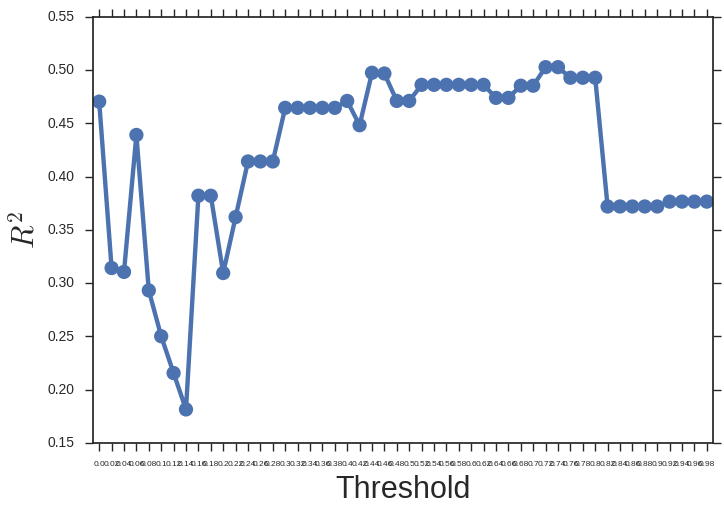

In [11]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which the $R^2$ is maximal: 

In [12]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.502699755101
Optimal threshold = 0.72


In [13]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

alphas_opt, preds_opt = perform_nested_lasso_cv(data_abs[selected_otus], hna)
r2_final = get_r2(hna, preds_opt)
print('r2: ' + str(r2_final))

Number of selected OTUs: 5
r2: 0.502699755101


Although the randomized Lasso is able to improve the performance, it still is much less than before. Still, we are left with 11 OTU's which are all directly correlated to the productivity. 

We can tune this threshold in function of the $R^2$ between the predicted HNA and productivity: 

In [14]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_prod_scores
for thresh in thresholds: 
    scores = otus_prod_scores[otus_prod_scores.values > thresh]
#scores_nested_mean = scores_nested_mean[scores_nested_mean > 0.16]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        #Check the R2 of the linear regression between the HNA-predictions and productivity 
        r2_scores[dummy] = linregress(prod[idx_prod],preds[idx_prod])[2]**2
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


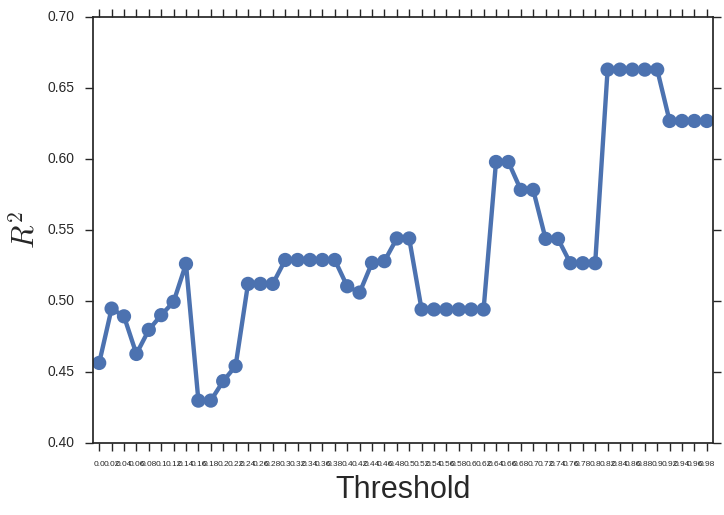

In [15]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Again, let's select the optimal threshold for the scores: 

In [16]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.662792261567
Optimal threshold = 0.82


In [17]:
optimal_scores = otus_prod_scores[otus_prod_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

Number of selected OTUs: 3


This gives us **3 OTU's** with a high $R^2$?

In [18]:
from analysis_functions import perform_nested_lasso_loocv
alphas, preds = perform_nested_lasso_loocv(data_abs.loc[idx_prod,selected_otus], prod)

print('R2 productivity: ' + str(str(get_r2(prod, preds))))

R2 productivity: 0.509697426181


This is surprisingly well. 

In [19]:
optimal_scores = pd.DataFrame(optimal_scores, index=selected_otus)
p = np.zeros(len(selected_otus))
r = np.zeros(len(selected_otus))
t = 0
for otu in selected_otus: 
    output = linregress(prod,data_abs.loc[idx_prod,otu])
    r[t] = output[2]
    p[t] = output[3]
    t+=1
optimal_scores['correlation'] = r
optimal_scores['p'] = p
display(optimal_scores)
    

,0,correlation,p
Otu000060,0.990,0.668000,0.001287
Otu000124,0.986,0.605500,0.004667
Otu000357,0.912,0.523813,0.017763


Let's visualize the selected OTU's: 

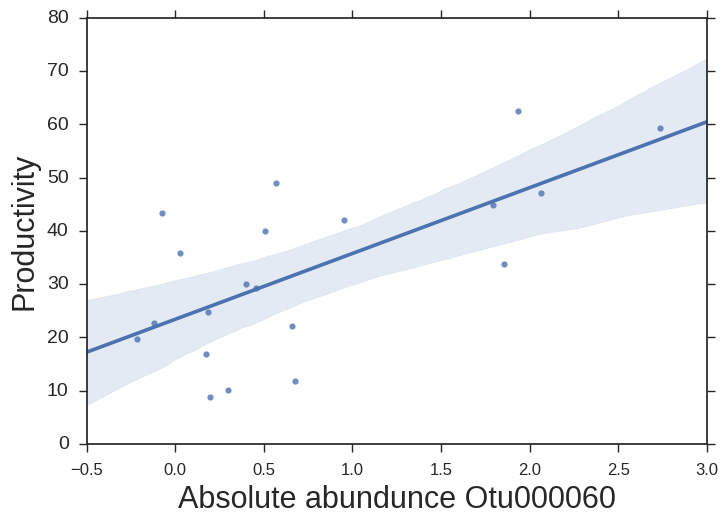

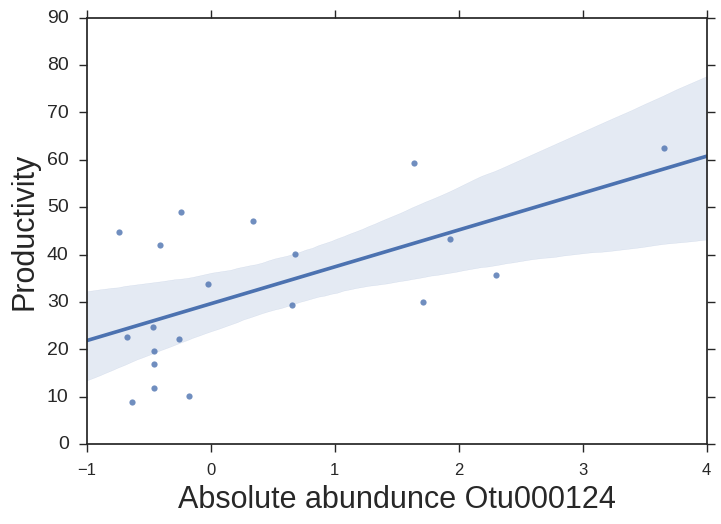

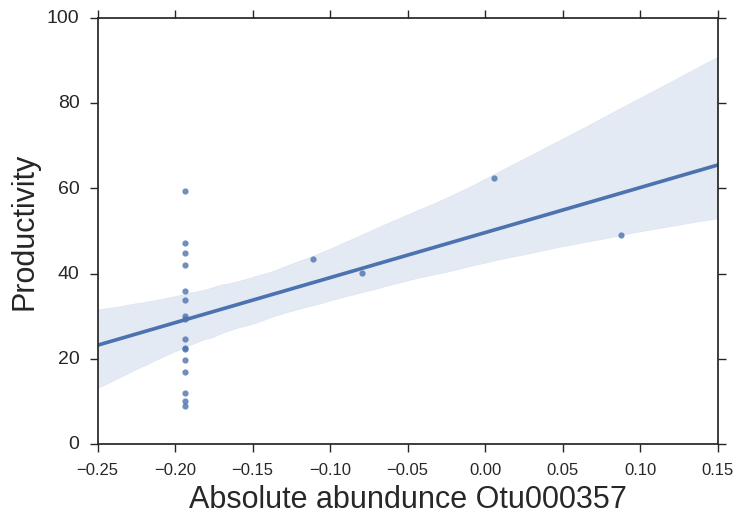

In [20]:
for otu in selected_otus: 
    plt.figure()
    sns.regplot(data_abs.loc[idx_prod, otu], prod)
    plt.xlabel('Absolute abundunce ' + otu, size=22)
    plt.xticks(size=12)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=14)
    plt.show()